In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def make_generator_network(
    input_size=20, num_hidden_layers=1, num_hidden_units=100, num_output_units=784
):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f"fc_g{i}", nn.Linear(input_size, num_hidden_units))
        model.add_module(f"relu_g{i}", nn.LeakyReLU())
        input_size = num_hidden_units

    model.add_module(
        f"fc_g{num_hidden_layers}", nn.Linear(input_size, num_output_units)
    )

    model.add_module("tanh_g", nn.Tanh())
    return model


## define a function for the discriminator:
def make_discriminator_network(
    input_size, num_hidden_layers=1, num_hidden_units=100, num_output_units=1
):

    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(
            f"fc_d{i}", nn.Linear(input_size, num_hidden_units, bias=False)
        )
        model.add_module(f"relu_d{i}", nn.LeakyReLU())
        model.add_module("dropout", nn.Dropout(p=0.5))
        input_size = num_hidden_units

    model.add_module(
        f"fc_d{num_hidden_layers}", nn.Linear(input_size, num_output_units)
    )
    model.add_module("sigmoid", nn.Sigmoid())
    return model

In [4]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size),
)
gen_model

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)

In [5]:
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size,
)
disc_model

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [6]:
image_path = "./data/"

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5)),
    ]
)
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True
)
example, label = next(iter(mnist_dataset))
print(f"Min: {example.min()} Max: {example.max()}")
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [7]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == "uniform":
        input_z = torch.rand(batch_size, z_size) * 2 - 1
    elif mode_z == "normal":
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [8]:
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = "uniform"
# 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)
print("input-z -- shape:", input_z.shape)
print("input-real -- shape:", input_real.shape)

g_output = gen_model(input_z)
print("Output of G -- shape:", g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print("Disc. (real) -- shape:", d_proba_real.shape)
print("Disc. (fake) -- shape:", d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [9]:
loss_fn = nn.BCELoss()
## Loss for the Generator
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f"Generator Loss: {g_loss:.4f}")

Generator Loss: 0.6983


In [10]:
## Loss for the Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f"Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}")

Discriminator Losses: Real 0.7479 Fake 0.6885


In [27]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(
    mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size),
).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size,
).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [28]:
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


## Train the generator
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [29]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
        f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
        f' [D-Real: {all_d_real[-1]:.4f}'
        f' D-Fake: {all_d_fake[-1]:.4f}]')
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy()
    )

Epoch 001 | Avg Losses >> G/D 0.8799/0.9412 [D-Real: 0.7833 D-Fake: 0.4746]
Epoch 002 | Avg Losses >> G/D 0.8710/1.2295 [D-Real: 0.5729 D-Fake: 0.4559]
Epoch 003 | Avg Losses >> G/D 0.9381/1.2007 [D-Real: 0.5783 D-Fake: 0.4275]
Epoch 004 | Avg Losses >> G/D 0.9508/1.2099 [D-Real: 0.5784 D-Fake: 0.4260]
Epoch 005 | Avg Losses >> G/D 0.9088/1.2365 [D-Real: 0.5663 D-Fake: 0.4367]
Epoch 006 | Avg Losses >> G/D 0.9151/1.2218 [D-Real: 0.5712 D-Fake: 0.4274]
Epoch 007 | Avg Losses >> G/D 0.8840/1.2661 [D-Real: 0.5522 D-Fake: 0.4426]
Epoch 008 | Avg Losses >> G/D 1.0248/1.1667 [D-Real: 0.5923 D-Fake: 0.4056]
Epoch 009 | Avg Losses >> G/D 1.0757/1.1434 [D-Real: 0.6090 D-Fake: 0.3951]
Epoch 010 | Avg Losses >> G/D 1.0845/1.1155 [D-Real: 0.6183 D-Fake: 0.3863]
Epoch 011 | Avg Losses >> G/D 1.1976/1.0706 [D-Real: 0.6402 D-Fake: 0.3647]
Epoch 012 | Avg Losses >> G/D 1.0875/1.1297 [D-Real: 0.6138 D-Fake: 0.3898]
Epoch 013 | Avg Losses >> G/D 1.0093/1.1672 [D-Real: 0.6006 D-Fake: 0.4030]
Epoch 014 | 

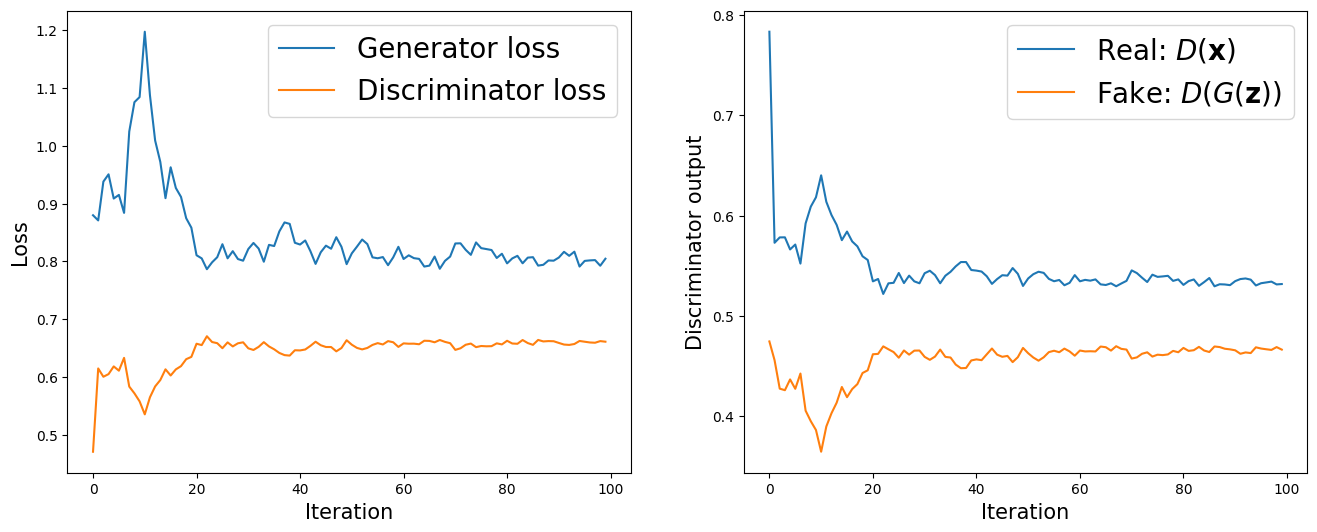

In [33]:
import itertools
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

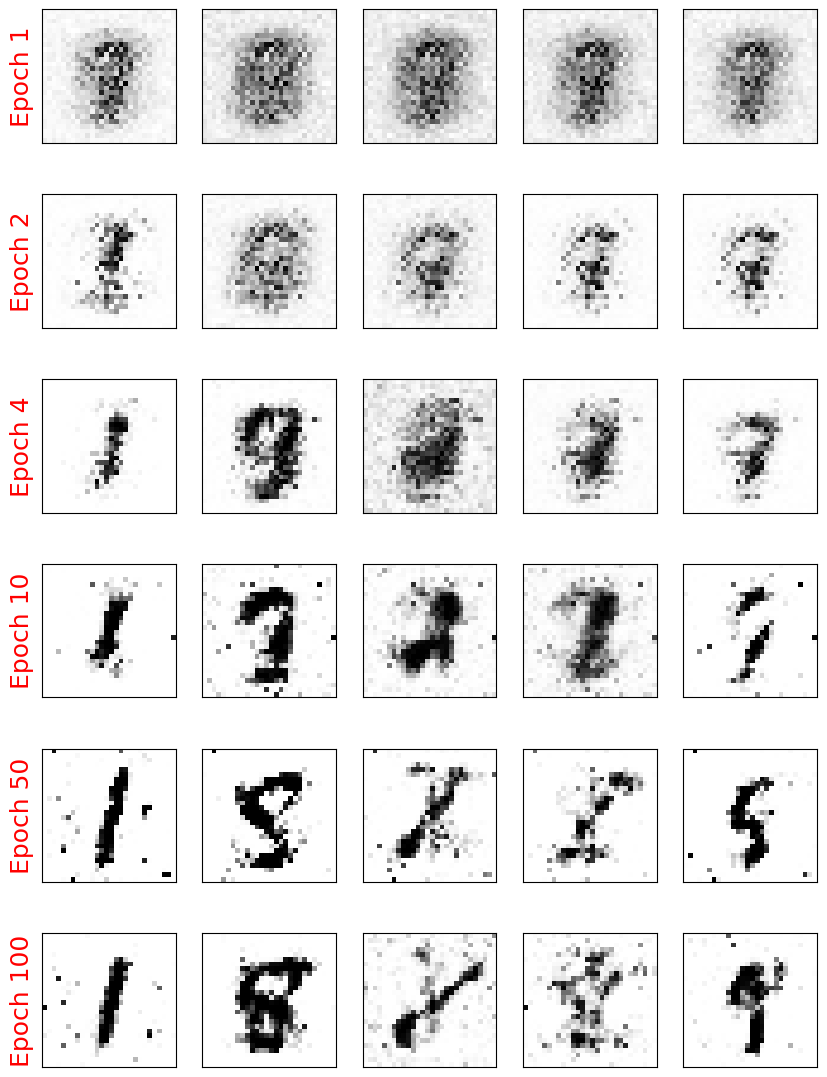

In [36]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06,
                0.5,
                f"Epoch {e}",
                rotation=90,
                size=18,
                color="red",
                horizontalalignment="right",
                verticalalignment="center",
                transform=ax.transAxes,
            )

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()